In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("/home/mizworski/Repos/xgboost/python-package/")
sys.path.append("/home/mizworski/Repos/LightGBM/python-package/")
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from datetime import datetime
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.utils.validation import column_or_1d
from scipy import interp
from scipy import stats

In [2]:
df = pd.read_csv('../data/bank-classification.csv', index_col=0)
df = df.sample(frac=1)

df.head()

,birth_date,job,marital,education,default,housing,loan,contact_date,contact,campaign,pdays,previous,poutcome,y
id,,,,,,,,,,,,,,
2549,1961-02-08,services,divorced,high.school,no,unknown,unknown,2008-05-13,telephone,3,999,0,nonexistent,unknown
6233,1980-10-03,services,married,high.school,no,no,no,2008-05-27,telephone,1,999,0,nonexistent,unknown
8324,1958-08-23,blue-collar,married,basic.4y,unknown,no,yes,2008-06-10,telephone,5,999,0,nonexistent,no
4227,1972-05-24,blue-collar,married,basic.9y,no,yes,no,2008-05-13,telephone,1,999,0,nonexistent,no
27082,1955-10-03,self-employed,married,university.degree,no,yes,no,2008-11-14,cellular,1,999,0,nonexistent,yes


In [48]:
date_parse_format = '%Y-%m-%d'

def preprocess_data(data):
    now = datetime.strptime(data.contact_date.max(), date_parse_format)
#     data['sum_nan'] = (data[['default', 'loan', 'education', 'housing', 'job']] == 'unknown').sum(axis=1)
    data['age'] = data.apply(lambda r: int((now - datetime.strptime(r.birth_date, date_parse_format)).days / 365.25), axis=1)
    data.drop('birth_date', axis=1, inplace=True)
#     data['contact_weekday'] = data.apply(lambda r: (datetime.strptime(r.contact_date, date_parse_format)).weekday(), axis=1)
    
#     data['age_range'] = data['age'].apply(age2class)
#     data.drop('age', axis=1, inplace=True)11
#     categorical_cols = list(set(data.columns) - set(['birth_date', 'contact_date', 'pdays', 'campaign', 'y']))

    categorical_cols = list(set(data.columns) - 
                            set(['birth_date', 'contact_date', 'campaign', 'previous','pdays', 'y','age', 'sum_nan']))
    X = pd.get_dummies(data, columns=categorical_cols)
    X['contacted'] = pd.get_dummies(X.pdays < 999, drop_first=True)
    
    X['days_since_contact'] =  X.apply(lambda r: ((now - datetime.strptime(r.contact_date, date_parse_format)).days), 
                                       axis=1)
    
    X.drop('contact_date', axis=1, inplace=True)
    
    train_x = X[X.y != 'unknown']
    test_x = X[X.y == 'unknown']
    train_y = train_x['y']
    train_y = pd.get_dummies(train_y, drop_first=True)
    train_x = train_x.drop('y', axis=1)
    test_x = test_x.drop('y', axis=1)
    
#     train_y = column_or_1d(train_y)
#     train_x = train_x.as_matrix()
#     test_x = test_x.as_matrix()
    
    return train_x, train_y, test_x
    

In [49]:

X_train, Y_train, X_test = preprocess_data(df.copy())

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numpy import random
from sklearn.preprocessing import PolynomialFeatures

In [50]:
X_train.iloc[0]

campaign                           5
pdays                            999
previous                           0
age                               52
poutcome_failure                   0
poutcome_nonexistent               1
poutcome_success                   0
job_admin.                         0
job_blue-collar                    1
job_entrepreneur                   0
job_housemaid                      0
job_management                     0
job_retired                        0
job_self-employed                  0
job_services                       0
job_student                        0
job_technician                     0
job_unemployed                     0
job_unknown                        0
housing_no                         1
housing_unknown                    0
housing_yes                        0
marital_divorced                   0
marital_married                    1
marital_single                     0
marital_unknown                    0
default_no                         0
d

In [51]:
X_train.head()

,campaign,pdays,previous,age,poutcome_failure,poutcome_nonexistent,poutcome_success,job_admin.,job_blue-collar,job_entrepreneur,...,education_professional.course,education_university.degree,education_unknown,contact_cellular,contact_telephone,loan_no,loan_unknown,loan_yes,contacted,days_since_contact
id,,,,,,,,,,,,,,,,,,,,,
8324,5,999,0,52,0,1,0,0,1,0,...,0,0,0,0,1,0,0,1,0,903
4227,1,999,0,38,0,1,0,0,1,0,...,0,0,0,0,1,1,0,0,0,931
27082,1,999,0,55,0,1,0,0,0,0,...,0,1,0,1,0,1,0,0,0,746
11616,13,999,0,54,0,1,0,0,0,0,...,0,0,1,0,1,1,0,0,0,886
36591,1,999,1,52,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,530


In [52]:
# model = XGBClassifier(max_depth=4, gamma=3, reg_alpha=0.2137, min_child_weight=2, n_estimators=880,
#                       reg_lambda=1, subsample=1, max_delta_step=5, learning_rate=0.006)
cv = StratifiedKFold(n_splits=10)


X = X_train.as_matrix()
Y = column_or_1d(Y_train)

In [53]:
import lightgbm as lgb

Start training...
[1]	valid_0's l2: 0.233341	valid_0's auc: 0.788553
[2]	valid_0's l2: 0.218263	valid_0's auc: 0.787973
[3]	valid_0's l2: 0.204667	valid_0's auc: 0.788925
[4]	valid_0's l2: 0.193	valid_0's auc: 0.787636
[5]	valid_0's l2: 0.181898	valid_0's auc: 0.786107
[6]	valid_0's l2: 0.171814	valid_0's auc: 0.787593
[7]	valid_0's l2: 0.162789	valid_0's auc: 0.787832
[8]	valid_0's l2: 0.16641	valid_0's auc: 0.787782
[9]	valid_0's l2: 0.157871	valid_0's auc: 0.788556
[10]	valid_0's l2: 0.150089	valid_0's auc: 0.789345
[11]	valid_0's l2: 0.143099	valid_0's auc: 0.789096
[12]	valid_0's l2: 0.145668	valid_0's auc: 0.789412
[13]	valid_0's l2: 0.139119	valid_0's auc: 0.789196
[14]	valid_0's l2: 0.133198	valid_0's auc: 0.789213
[15]	valid_0's l2: 0.128139	valid_0's auc: 0.789467
[16]	valid_0's l2: 0.123358	valid_0's auc: 0.789437
[17]	valid_0's l2: 0.119188	valid_0's auc: 0.790051
[18]	valid_0's l2: 0.115228	valid_0's auc: 0.789621
[19]	valid_0's l2: 0.111586	valid_0's auc: 0.788895
[20]	va

[155]	valid_0's l2: 0.0804728	valid_0's auc: 0.798195
[156]	valid_0's l2: 0.0806308	valid_0's auc: 0.798266
[157]	valid_0's l2: 0.0807198	valid_0's auc: 0.798295
[158]	valid_0's l2: 0.0808715	valid_0's auc: 0.798289
[159]	valid_0's l2: 0.0810403	valid_0's auc: 0.7982
[160]	valid_0's l2: 0.0812106	valid_0's auc: 0.798227
[161]	valid_0's l2: 0.0808558	valid_0's auc: 0.798495
[162]	valid_0's l2: 0.0810023	valid_0's auc: 0.798526
[163]	valid_0's l2: 0.0807413	valid_0's auc: 0.798348
[164]	valid_0's l2: 0.0804127	valid_0's auc: 0.799413
[165]	valid_0's l2: 0.0802098	valid_0's auc: 0.799342
[166]	valid_0's l2: 0.080062	valid_0's auc: 0.798282
[167]	valid_0's l2: 0.0798503	valid_0's auc: 0.797926
[168]	valid_0's l2: 0.0797139	valid_0's auc: 0.797408
[169]	valid_0's l2: 0.0795236	valid_0's auc: 0.797175
[170]	valid_0's l2: 0.0796336	valid_0's auc: 0.797198
[171]	valid_0's l2: 0.0795	valid_0's auc: 0.79701
[172]	valid_0's l2: 0.0796134	valid_0's auc: 0.797044
[173]	valid_0's l2: 0.0795322	valid

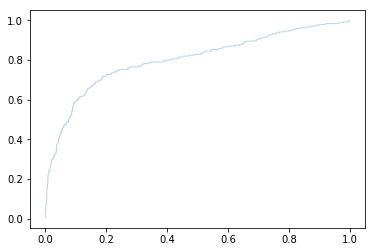

Plot feature importances...


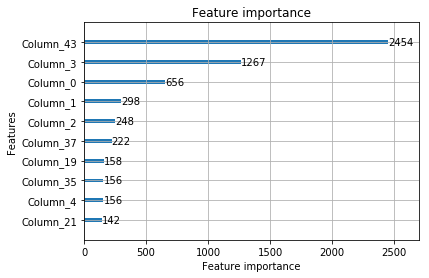

[1]	valid_0's l2: 0.233246	valid_0's auc: 0.794231
[2]	valid_0's l2: 0.218173	valid_0's auc: 0.798008
[3]	valid_0's l2: 0.20451	valid_0's auc: 0.798608
[4]	valid_0's l2: 0.19278	valid_0's auc: 0.802071
[5]	valid_0's l2: 0.181616	valid_0's auc: 0.803008
[6]	valid_0's l2: 0.171565	valid_0's auc: 0.803641
[7]	valid_0's l2: 0.162473	valid_0's auc: 0.802722
[8]	valid_0's l2: 0.166038	valid_0's auc: 0.802881
[9]	valid_0's l2: 0.157508	valid_0's auc: 0.802881
[10]	valid_0's l2: 0.149822	valid_0's auc: 0.802358
[11]	valid_0's l2: 0.142842	valid_0's auc: 0.802689
[12]	valid_0's l2: 0.145428	valid_0's auc: 0.802694
[13]	valid_0's l2: 0.138883	valid_0's auc: 0.802628
[14]	valid_0's l2: 0.132986	valid_0's auc: 0.802716
[15]	valid_0's l2: 0.127881	valid_0's auc: 0.802638
[16]	valid_0's l2: 0.123017	valid_0's auc: 0.802414
[17]	valid_0's l2: 0.118792	valid_0's auc: 0.805221
[18]	valid_0's l2: 0.114669	valid_0's auc: 0.805457
[19]	valid_0's l2: 0.110918	valid_0's auc: 0.805708
[20]	valid_0's l2: 0.10

[159]	valid_0's l2: 0.0790378	valid_0's auc: 0.814036
[160]	valid_0's l2: 0.0792199	valid_0's auc: 0.814081
[161]	valid_0's l2: 0.0788769	valid_0's auc: 0.814086
[162]	valid_0's l2: 0.0790287	valid_0's auc: 0.813994
[163]	valid_0's l2: 0.0787111	valid_0's auc: 0.814338
[164]	valid_0's l2: 0.0784011	valid_0's auc: 0.814447
[165]	valid_0's l2: 0.0781551	valid_0's auc: 0.813796
[166]	valid_0's l2: 0.0779491	valid_0's auc: 0.814108
[167]	valid_0's l2: 0.077726	valid_0's auc: 0.813898
[168]	valid_0's l2: 0.0776037	valid_0's auc: 0.813435
[169]	valid_0's l2: 0.0773932	valid_0's auc: 0.81361
[170]	valid_0's l2: 0.0775071	valid_0's auc: 0.813585
[171]	valid_0's l2: 0.0773842	valid_0's auc: 0.814137
[172]	valid_0's l2: 0.0775001	valid_0's auc: 0.814071
[173]	valid_0's l2: 0.0773454	valid_0's auc: 0.814021
[174]	valid_0's l2: 0.0771828	valid_0's auc: 0.814301
[175]	valid_0's l2: 0.0770153	valid_0's auc: 0.813718
[176]	valid_0's l2: 0.0770908	valid_0's auc: 0.813775
[177]	valid_0's l2: 0.0771891	

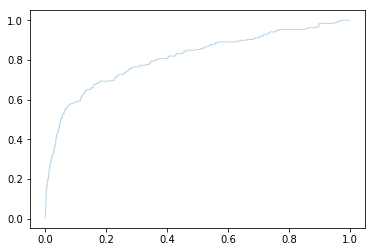

Plot feature importances...


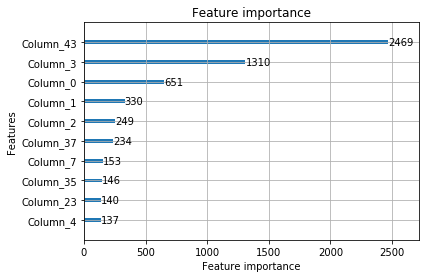

[1]	valid_0's l2: 0.233175	valid_0's auc: 0.805281
[2]	valid_0's l2: 0.218018	valid_0's auc: 0.80532
[3]	valid_0's l2: 0.204313	valid_0's auc: 0.805242
[4]	valid_0's l2: 0.192633	valid_0's auc: 0.799707
[5]	valid_0's l2: 0.181474	valid_0's auc: 0.799727
[6]	valid_0's l2: 0.171376	valid_0's auc: 0.800329
[7]	valid_0's l2: 0.16231	valid_0's auc: 0.800835
[8]	valid_0's l2: 0.165931	valid_0's auc: 0.800784
[9]	valid_0's l2: 0.157358	valid_0's auc: 0.802024
[10]	valid_0's l2: 0.149619	valid_0's auc: 0.802344
[11]	valid_0's l2: 0.14267	valid_0's auc: 0.80169
[12]	valid_0's l2: 0.145251	valid_0's auc: 0.80171
[13]	valid_0's l2: 0.138686	valid_0's auc: 0.801787
[14]	valid_0's l2: 0.132738	valid_0's auc: 0.801901
[15]	valid_0's l2: 0.127752	valid_0's auc: 0.800807
[16]	valid_0's l2: 0.122855	valid_0's auc: 0.800471
[17]	valid_0's l2: 0.118728	valid_0's auc: 0.798912
[18]	valid_0's l2: 0.114745	valid_0's auc: 0.799597
[19]	valid_0's l2: 0.11115	valid_0's auc: 0.803911
[20]	valid_0's l2: 0.107839

[166]	valid_0's l2: 0.0788835	valid_0's auc: 0.803827
[167]	valid_0's l2: 0.0786635	valid_0's auc: 0.803788
[168]	valid_0's l2: 0.0785687	valid_0's auc: 0.803723
[169]	valid_0's l2: 0.0783644	valid_0's auc: 0.80373
[170]	valid_0's l2: 0.0784736	valid_0's auc: 0.803687
[171]	valid_0's l2: 0.0783845	valid_0's auc: 0.803459
[172]	valid_0's l2: 0.0785007	valid_0's auc: 0.803457
[173]	valid_0's l2: 0.0784169	valid_0's auc: 0.803298
[174]	valid_0's l2: 0.0782443	valid_0's auc: 0.803553
[175]	valid_0's l2: 0.0781234	valid_0's auc: 0.803551
[176]	valid_0's l2: 0.0781936	valid_0's auc: 0.803567
[177]	valid_0's l2: 0.0782912	valid_0's auc: 0.803526
[178]	valid_0's l2: 0.0783894	valid_0's auc: 0.803567
[179]	valid_0's l2: 0.0783224	valid_0's auc: 0.803455
[180]	valid_0's l2: 0.0784003	valid_0's auc: 0.803446
[181]	valid_0's l2: 0.0783346	valid_0's auc: 0.802784
[182]	valid_0's l2: 0.078209	valid_0's auc: 0.802166
[183]	valid_0's l2: 0.0781358	valid_0's auc: 0.802474
[184]	valid_0's l2: 0.0780546	

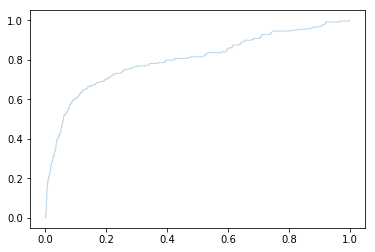

Plot feature importances...


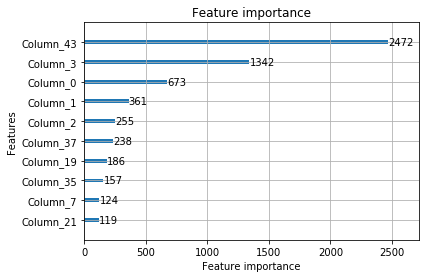

[1]	valid_0's l2: 0.23369	valid_0's auc: 0.750196
[2]	valid_0's l2: 0.218944	valid_0's auc: 0.752883
[3]	valid_0's l2: 0.20565	valid_0's auc: 0.754199
[4]	valid_0's l2: 0.194096	valid_0's auc: 0.756325
[5]	valid_0's l2: 0.183208	valid_0's auc: 0.759204
[6]	valid_0's l2: 0.173455	valid_0's auc: 0.757761
[7]	valid_0's l2: 0.16471	valid_0's auc: 0.756962
[8]	valid_0's l2: 0.168207	valid_0's auc: 0.757036
[9]	valid_0's l2: 0.160007	valid_0's auc: 0.756453
[10]	valid_0's l2: 0.152556	valid_0's auc: 0.75668
[11]	valid_0's l2: 0.145794	valid_0's auc: 0.756585
[12]	valid_0's l2: 0.148311	valid_0's auc: 0.756407
[13]	valid_0's l2: 0.14197	valid_0's auc: 0.756783
[14]	valid_0's l2: 0.136259	valid_0's auc: 0.756896
[15]	valid_0's l2: 0.131372	valid_0's auc: 0.757733
[16]	valid_0's l2: 0.126649	valid_0's auc: 0.758384
[17]	valid_0's l2: 0.122544	valid_0's auc: 0.759514
[18]	valid_0's l2: 0.118699	valid_0's auc: 0.759235
[19]	valid_0's l2: 0.115168	valid_0's auc: 0.763715
[20]	valid_0's l2: 0.11200

[161]	valid_0's l2: 0.0858535	valid_0's auc: 0.763356
[162]	valid_0's l2: 0.0859805	valid_0's auc: 0.763189
[163]	valid_0's l2: 0.0857261	valid_0's auc: 0.763029
[164]	valid_0's l2: 0.0854477	valid_0's auc: 0.762854
[165]	valid_0's l2: 0.0852665	valid_0's auc: 0.762426
[166]	valid_0's l2: 0.0850664	valid_0's auc: 0.762605
[167]	valid_0's l2: 0.084848	valid_0's auc: 0.762803
[168]	valid_0's l2: 0.0847135	valid_0's auc: 0.763611
[169]	valid_0's l2: 0.0845429	valid_0's auc: 0.763465
[170]	valid_0's l2: 0.084641	valid_0's auc: 0.763481
[171]	valid_0's l2: 0.0845329	valid_0's auc: 0.762477
[172]	valid_0's l2: 0.0846259	valid_0's auc: 0.76248
[173]	valid_0's l2: 0.0844694	valid_0's auc: 0.762554
[174]	valid_0's l2: 0.0842641	valid_0's auc: 0.764417
[175]	valid_0's l2: 0.084085	valid_0's auc: 0.765916
[176]	valid_0's l2: 0.0841336	valid_0's auc: 0.765932
[177]	valid_0's l2: 0.0842094	valid_0's auc: 0.766076
[178]	valid_0's l2: 0.0842962	valid_0's auc: 0.766082
[179]	valid_0's l2: 0.0841958	va

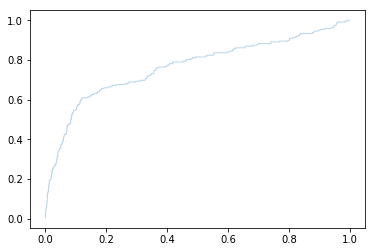

Plot feature importances...


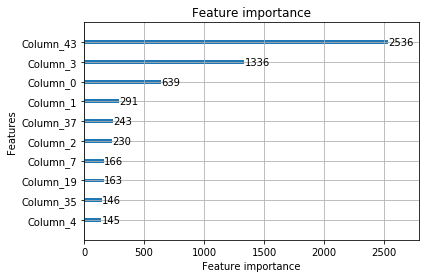

[1]	valid_0's l2: 0.233366	valid_0's auc: 0.753664
[2]	valid_0's l2: 0.21839	valid_0's auc: 0.753509
[3]	valid_0's l2: 0.204899	valid_0's auc: 0.751551
[4]	valid_0's l2: 0.193094	valid_0's auc: 0.761039
[5]	valid_0's l2: 0.182015	valid_0's auc: 0.761047
[6]	valid_0's l2: 0.172066	valid_0's auc: 0.762687
[7]	valid_0's l2: 0.163092	valid_0's auc: 0.762553
[8]	valid_0's l2: 0.166664	valid_0's auc: 0.762275
[9]	valid_0's l2: 0.158169	valid_0's auc: 0.763448
[10]	valid_0's l2: 0.15062	valid_0's auc: 0.762521
[11]	valid_0's l2: 0.143768	valid_0's auc: 0.762351
[12]	valid_0's l2: 0.146308	valid_0's auc: 0.762565
[13]	valid_0's l2: 0.13985	valid_0's auc: 0.762882
[14]	valid_0's l2: 0.13404	valid_0's auc: 0.762902
[15]	valid_0's l2: 0.128973	valid_0's auc: 0.7614
[16]	valid_0's l2: 0.124265	valid_0's auc: 0.761458
[17]	valid_0's l2: 0.120047	valid_0's auc: 0.76122
[18]	valid_0's l2: 0.116046	valid_0's auc: 0.761714
[19]	valid_0's l2: 0.112501	valid_0's auc: 0.762351
[20]	valid_0's l2: 0.109312	

[159]	valid_0's l2: 0.0824815	valid_0's auc: 0.768803
[160]	valid_0's l2: 0.0826434	valid_0's auc: 0.768835
[161]	valid_0's l2: 0.0823599	valid_0's auc: 0.768912
[162]	valid_0's l2: 0.0824841	valid_0's auc: 0.769039
[163]	valid_0's l2: 0.0821559	valid_0's auc: 0.769148
[164]	valid_0's l2: 0.0819217	valid_0's auc: 0.769205
[165]	valid_0's l2: 0.08169	valid_0's auc: 0.769466
[166]	valid_0's l2: 0.081517	valid_0's auc: 0.76889
[167]	valid_0's l2: 0.0813364	valid_0's auc: 0.768746
[168]	valid_0's l2: 0.0811839	valid_0's auc: 0.76909
[169]	valid_0's l2: 0.0809991	valid_0's auc: 0.769339
[170]	valid_0's l2: 0.0811018	valid_0's auc: 0.769273
[171]	valid_0's l2: 0.0809624	valid_0's auc: 0.768892
[172]	valid_0's l2: 0.0810646	valid_0's auc: 0.768894
[173]	valid_0's l2: 0.0809287	valid_0's auc: 0.768657
[174]	valid_0's l2: 0.080788	valid_0's auc: 0.768588
[175]	valid_0's l2: 0.0806666	valid_0's auc: 0.768668
[176]	valid_0's l2: 0.0807375	valid_0's auc: 0.768661
[177]	valid_0's l2: 0.0808268	vali

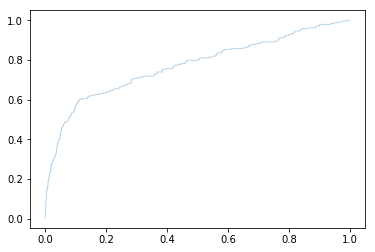

Plot feature importances...


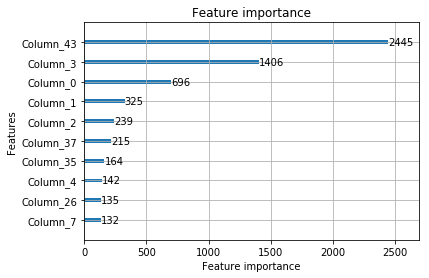

[1]	valid_0's l2: 0.233671	valid_0's auc: 0.753942
[2]	valid_0's l2: 0.218929	valid_0's auc: 0.755826
[3]	valid_0's l2: 0.205704	valid_0's auc: 0.752701
[4]	valid_0's l2: 0.194324	valid_0's auc: 0.75927
[5]	valid_0's l2: 0.183445	valid_0's auc: 0.760516
[6]	valid_0's l2: 0.173608	valid_0's auc: 0.761306
[7]	valid_0's l2: 0.16474	valid_0's auc: 0.761734
[8]	valid_0's l2: 0.168245	valid_0's auc: 0.76168
[9]	valid_0's l2: 0.159962	valid_0's auc: 0.761695
[10]	valid_0's l2: 0.152499	valid_0's auc: 0.761433
[11]	valid_0's l2: 0.145671	valid_0's auc: 0.761688
[12]	valid_0's l2: 0.148218	valid_0's auc: 0.76188
[13]	valid_0's l2: 0.141904	valid_0's auc: 0.761634
[14]	valid_0's l2: 0.13619	valid_0's auc: 0.761957
[15]	valid_0's l2: 0.131309	valid_0's auc: 0.761048
[16]	valid_0's l2: 0.126702	valid_0's auc: 0.760737
[17]	valid_0's l2: 0.12268	valid_0's auc: 0.76158
[18]	valid_0's l2: 0.118817	valid_0's auc: 0.761299
[19]	valid_0's l2: 0.115328	valid_0's auc: 0.761451
[20]	valid_0's l2: 0.112191	

[162]	valid_0's l2: 0.0863513	valid_0's auc: 0.768874
[163]	valid_0's l2: 0.0861223	valid_0's auc: 0.768906
[164]	valid_0's l2: 0.0858468	valid_0's auc: 0.768827
[165]	valid_0's l2: 0.0856629	valid_0's auc: 0.768003
[166]	valid_0's l2: 0.0855128	valid_0's auc: 0.768243
[167]	valid_0's l2: 0.0852963	valid_0's auc: 0.768179
[168]	valid_0's l2: 0.0852036	valid_0's auc: 0.76735
[169]	valid_0's l2: 0.0851117	valid_0's auc: 0.766536
[170]	valid_0's l2: 0.0851941	valid_0's auc: 0.766534
[171]	valid_0's l2: 0.0851098	valid_0's auc: 0.76616
[172]	valid_0's l2: 0.0851991	valid_0's auc: 0.766126
[173]	valid_0's l2: 0.0851009	valid_0's auc: 0.765642
[174]	valid_0's l2: 0.0849605	valid_0's auc: 0.765914
[175]	valid_0's l2: 0.084859	valid_0's auc: 0.76572
[176]	valid_0's l2: 0.0849163	valid_0's auc: 0.76574
[177]	valid_0's l2: 0.0849912	valid_0's auc: 0.765736
[178]	valid_0's l2: 0.0850723	valid_0's auc: 0.765738
[179]	valid_0's l2: 0.0848873	valid_0's auc: 0.765941
[180]	valid_0's l2: 0.0849542	val

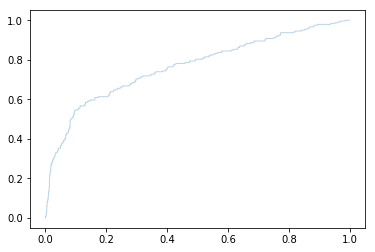

Plot feature importances...


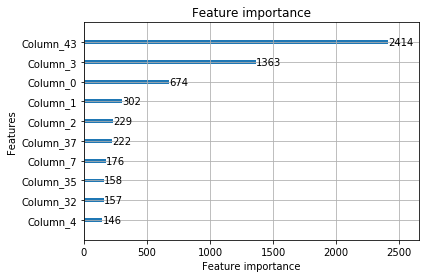

[1]	valid_0's l2: 0.233345	valid_0's auc: 0.782587
[2]	valid_0's l2: 0.21831	valid_0's auc: 0.782435
[3]	valid_0's l2: 0.20474	valid_0's auc: 0.784443
[4]	valid_0's l2: 0.193078	valid_0's auc: 0.79116
[5]	valid_0's l2: 0.181985	valid_0's auc: 0.790901
[6]	valid_0's l2: 0.171982	valid_0's auc: 0.791067
[7]	valid_0's l2: 0.162982	valid_0's auc: 0.789902
[8]	valid_0's l2: 0.16655	valid_0's auc: 0.789732
[9]	valid_0's l2: 0.15811	valid_0's auc: 0.789376
[10]	valid_0's l2: 0.150488	valid_0's auc: 0.789365
[11]	valid_0's l2: 0.143532	valid_0's auc: 0.789475
[12]	valid_0's l2: 0.146093	valid_0's auc: 0.790003
[13]	valid_0's l2: 0.139599	valid_0's auc: 0.790085
[14]	valid_0's l2: 0.133674	valid_0's auc: 0.790232
[15]	valid_0's l2: 0.128693	valid_0's auc: 0.789653
[16]	valid_0's l2: 0.123915	valid_0's auc: 0.788555
[17]	valid_0's l2: 0.119847	valid_0's auc: 0.789317
[18]	valid_0's l2: 0.115897	valid_0's auc: 0.789093
[19]	valid_0's l2: 0.112314	valid_0's auc: 0.789324
[20]	valid_0's l2: 0.10912

[159]	valid_0's l2: 0.0818713	valid_0's auc: 0.792013
[160]	valid_0's l2: 0.08204	valid_0's auc: 0.792054
[161]	valid_0's l2: 0.0817909	valid_0's auc: 0.791659
[162]	valid_0's l2: 0.0819378	valid_0's auc: 0.791666
[163]	valid_0's l2: 0.0816363	valid_0's auc: 0.792058
[164]	valid_0's l2: 0.0813645	valid_0's auc: 0.792058
[165]	valid_0's l2: 0.081146	valid_0's auc: 0.792519
[166]	valid_0's l2: 0.0809423	valid_0's auc: 0.792277
[167]	valid_0's l2: 0.0807642	valid_0's auc: 0.792024
[168]	valid_0's l2: 0.0806627	valid_0's auc: 0.792511
[169]	valid_0's l2: 0.0804706	valid_0's auc: 0.792953
[170]	valid_0's l2: 0.0805729	valid_0's auc: 0.792921
[171]	valid_0's l2: 0.0804549	valid_0's auc: 0.793261
[172]	valid_0's l2: 0.0805634	valid_0's auc: 0.793288
[173]	valid_0's l2: 0.0804394	valid_0's auc: 0.792592
[174]	valid_0's l2: 0.0802605	valid_0's auc: 0.792815
[175]	valid_0's l2: 0.0801256	valid_0's auc: 0.79264
[176]	valid_0's l2: 0.0801903	valid_0's auc: 0.792694
[177]	valid_0's l2: 0.0802808	va

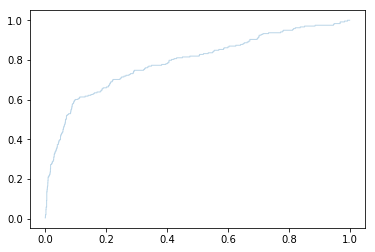

Plot feature importances...


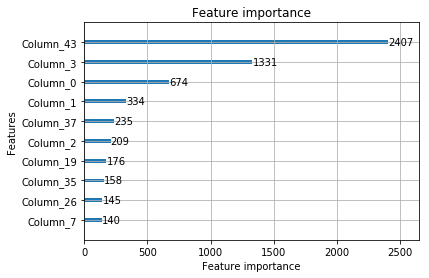

[1]	valid_0's l2: 0.23344	valid_0's auc: 0.798525
[2]	valid_0's l2: 0.218454	valid_0's auc: 0.799599
[3]	valid_0's l2: 0.204988	valid_0's auc: 0.799326
[4]	valid_0's l2: 0.193256	valid_0's auc: 0.806289
[5]	valid_0's l2: 0.182265	valid_0's auc: 0.806906
[6]	valid_0's l2: 0.172269	valid_0's auc: 0.808914
[7]	valid_0's l2: 0.163286	valid_0's auc: 0.808127
[8]	valid_0's l2: 0.166851	valid_0's auc: 0.808305
[9]	valid_0's l2: 0.158412	valid_0's auc: 0.808243
[10]	valid_0's l2: 0.150738	valid_0's auc: 0.808306
[11]	valid_0's l2: 0.143891	valid_0's auc: 0.807756
[12]	valid_0's l2: 0.146408	valid_0's auc: 0.807899
[13]	valid_0's l2: 0.139862	valid_0's auc: 0.808435
[14]	valid_0's l2: 0.133964	valid_0's auc: 0.80788
[15]	valid_0's l2: 0.128865	valid_0's auc: 0.808832
[16]	valid_0's l2: 0.124133	valid_0's auc: 0.809094
[17]	valid_0's l2: 0.119947	valid_0's auc: 0.808774
[18]	valid_0's l2: 0.116024	valid_0's auc: 0.809094
[19]	valid_0's l2: 0.112502	valid_0's auc: 0.808901
[20]	valid_0's l2: 0.10

[159]	valid_0's l2: 0.0815788	valid_0's auc: 0.820206
[160]	valid_0's l2: 0.0817443	valid_0's auc: 0.820375
[161]	valid_0's l2: 0.0815004	valid_0's auc: 0.82027
[162]	valid_0's l2: 0.0816278	valid_0's auc: 0.82021
[163]	valid_0's l2: 0.0813486	valid_0's auc: 0.820165
[164]	valid_0's l2: 0.0810363	valid_0's auc: 0.820052
[165]	valid_0's l2: 0.0808203	valid_0's auc: 0.820352
[166]	valid_0's l2: 0.080628	valid_0's auc: 0.820458
[167]	valid_0's l2: 0.0804079	valid_0's auc: 0.820015
[168]	valid_0's l2: 0.0802473	valid_0's auc: 0.819671
[169]	valid_0's l2: 0.0801443	valid_0's auc: 0.819039
[170]	valid_0's l2: 0.0802495	valid_0's auc: 0.819174
[171]	valid_0's l2: 0.0801044	valid_0's auc: 0.819083
[172]	valid_0's l2: 0.0802072	valid_0's auc: 0.818932
[173]	valid_0's l2: 0.0800732	valid_0's auc: 0.819295
[174]	valid_0's l2: 0.0799549	valid_0's auc: 0.818681
[175]	valid_0's l2: 0.07987	valid_0's auc: 0.818177
[176]	valid_0's l2: 0.0799409	valid_0's auc: 0.818225
[177]	valid_0's l2: 0.0800277	val

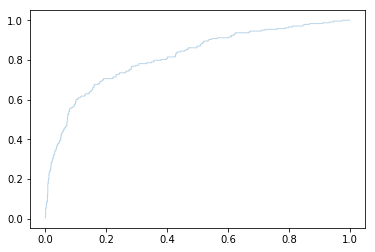

Plot feature importances...


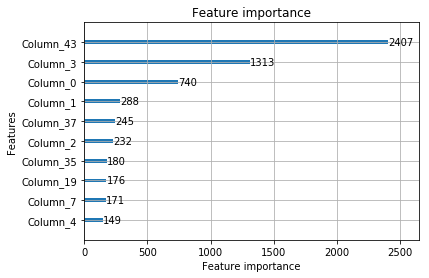

[1]	valid_0's l2: 0.233357	valid_0's auc: 0.780078
[2]	valid_0's l2: 0.218365	valid_0's auc: 0.77996
[3]	valid_0's l2: 0.204887	valid_0's auc: 0.779927
[4]	valid_0's l2: 0.193298	valid_0's auc: 0.779927
[5]	valid_0's l2: 0.182258	valid_0's auc: 0.779818
[6]	valid_0's l2: 0.172287	valid_0's auc: 0.780534
[7]	valid_0's l2: 0.163247	valid_0's auc: 0.780916
[8]	valid_0's l2: 0.166813	valid_0's auc: 0.780969
[9]	valid_0's l2: 0.158354	valid_0's auc: 0.781172
[10]	valid_0's l2: 0.150701	valid_0's auc: 0.781423
[11]	valid_0's l2: 0.143807	valid_0's auc: 0.780832
[12]	valid_0's l2: 0.146355	valid_0's auc: 0.78082
[13]	valid_0's l2: 0.139875	valid_0's auc: 0.780866
[14]	valid_0's l2: 0.134021	valid_0's auc: 0.781149
[15]	valid_0's l2: 0.129014	valid_0's auc: 0.780626
[16]	valid_0's l2: 0.124169	valid_0's auc: 0.780537
[17]	valid_0's l2: 0.120098	valid_0's auc: 0.781093
[18]	valid_0's l2: 0.116195	valid_0's auc: 0.781468
[19]	valid_0's l2: 0.11265	valid_0's auc: 0.781473
[20]	valid_0's l2: 0.109

[156]	valid_0's l2: 0.0826177	valid_0's auc: 0.790501
[157]	valid_0's l2: 0.0827037	valid_0's auc: 0.790476
[158]	valid_0's l2: 0.0828652	valid_0's auc: 0.790453
[159]	valid_0's l2: 0.0830294	valid_0's auc: 0.790449
[160]	valid_0's l2: 0.0832012	valid_0's auc: 0.790496
[161]	valid_0's l2: 0.0827808	valid_0's auc: 0.792629
[162]	valid_0's l2: 0.0829235	valid_0's auc: 0.79257
[163]	valid_0's l2: 0.0826543	valid_0's auc: 0.792575
[164]	valid_0's l2: 0.0822791	valid_0's auc: 0.793904
[165]	valid_0's l2: 0.0820869	valid_0's auc: 0.793579
[166]	valid_0's l2: 0.0819564	valid_0's auc: 0.792253
[167]	valid_0's l2: 0.0817767	valid_0's auc: 0.792221
[168]	valid_0's l2: 0.0816314	valid_0's auc: 0.793062
[169]	valid_0's l2: 0.0814541	valid_0's auc: 0.792904
[170]	valid_0's l2: 0.0815657	valid_0's auc: 0.792865
[171]	valid_0's l2: 0.0814409	valid_0's auc: 0.793484
[172]	valid_0's l2: 0.0815448	valid_0's auc: 0.793547
[173]	valid_0's l2: 0.0814398	valid_0's auc: 0.793423
[174]	valid_0's l2: 0.0812826

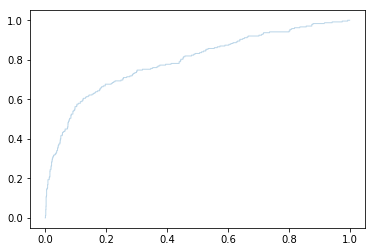

Plot feature importances...


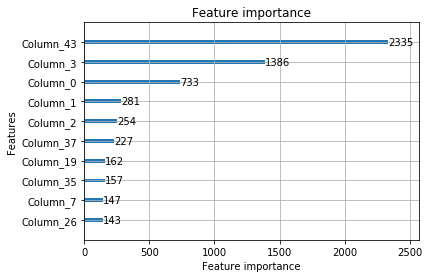

[1]	valid_0's l2: 0.233262	valid_0's auc: 0.780326
[2]	valid_0's l2: 0.218209	valid_0's auc: 0.780141
[3]	valid_0's l2: 0.204663	valid_0's auc: 0.779582
[4]	valid_0's l2: 0.192899	valid_0's auc: 0.784995
[5]	valid_0's l2: 0.181747	valid_0's auc: 0.785836
[6]	valid_0's l2: 0.171767	valid_0's auc: 0.785487
[7]	valid_0's l2: 0.162755	valid_0's auc: 0.785329
[8]	valid_0's l2: 0.166308	valid_0's auc: 0.785519
[9]	valid_0's l2: 0.157854	valid_0's auc: 0.78544
[10]	valid_0's l2: 0.150274	valid_0's auc: 0.785191
[11]	valid_0's l2: 0.143417	valid_0's auc: 0.784917
[12]	valid_0's l2: 0.145994	valid_0's auc: 0.784885
[13]	valid_0's l2: 0.139435	valid_0's auc: 0.784934
[14]	valid_0's l2: 0.133505	valid_0's auc: 0.785356
[15]	valid_0's l2: 0.128489	valid_0's auc: 0.784044
[16]	valid_0's l2: 0.123744	valid_0's auc: 0.784798
[17]	valid_0's l2: 0.119626	valid_0's auc: 0.782128
[18]	valid_0's l2: 0.115635	valid_0's auc: 0.782701
[19]	valid_0's l2: 0.112046	valid_0's auc: 0.782481
[20]	valid_0's l2: 0.1

[159]	valid_0's l2: 0.0811312	valid_0's auc: 0.785149
[160]	valid_0's l2: 0.0813038	valid_0's auc: 0.785321
[161]	valid_0's l2: 0.0808807	valid_0's auc: 0.786539
[162]	valid_0's l2: 0.0810234	valid_0's auc: 0.786451
[163]	valid_0's l2: 0.0806735	valid_0's auc: 0.787312
[164]	valid_0's l2: 0.0803537	valid_0's auc: 0.787629
[165]	valid_0's l2: 0.0801335	valid_0's auc: 0.787917
[166]	valid_0's l2: 0.0799853	valid_0's auc: 0.787832
[167]	valid_0's l2: 0.0797987	valid_0's auc: 0.788003
[168]	valid_0's l2: 0.0796435	valid_0's auc: 0.788326
[169]	valid_0's l2: 0.0794993	valid_0's auc: 0.788106
[170]	valid_0's l2: 0.0796077	valid_0's auc: 0.788138
[171]	valid_0's l2: 0.0794741	valid_0's auc: 0.788029
[172]	valid_0's l2: 0.0795796	valid_0's auc: 0.788031
[173]	valid_0's l2: 0.0794786	valid_0's auc: 0.788307
[174]	valid_0's l2: 0.0793542	valid_0's auc: 0.788227
[175]	valid_0's l2: 0.0792	valid_0's auc: 0.787679
[176]	valid_0's l2: 0.0792696	valid_0's auc: 0.787679
[177]	valid_0's l2: 0.0793649	v

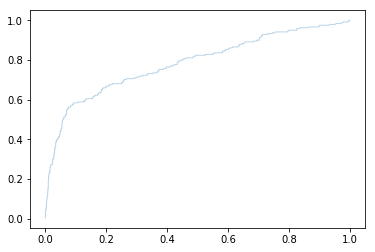

Plot feature importances...


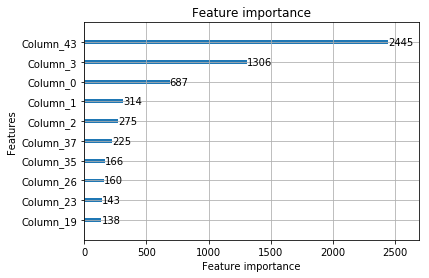

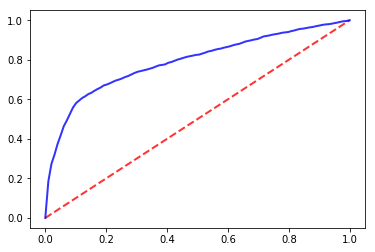

In [56]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
i=0
params = {
    'task': 'train',
    'boosting_type': 'dart',
    'objective': 'binary',
    'metric': {'l2', 'auc'},
    'num_leaves': 32,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 16,
    'verbose': 0,
    'is_unbalacne': False,
}

print('Start training...')
model = lgb.LGBMClassifier(nthread=4,silent=False, bagging_fraction= 0.8, bagging_freq= 16,
                                boosting_type= 'dart',colsample_bytree= 0.8,feature_fraction= 0.8,
                                is_unbalance= False, num_boosting_rounds=256)
# train
for train, test in cv.split(X, Y):
    lgb_train = lgb.Dataset(X[train], Y[train])
    lgb_eval = lgb.Dataset(X[test], Y[test], reference=lgb_train)
    
    gbm = lgb.train(params,
                lgb_train,
                num_boost_round=256,
                valid_sets=lgb_eval,
#                 early_stopping_rounds=32
                   )
    y_pred = gbm.predict(X[test], num_iteration=gbm.best_iteration)
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(Y[test], y_pred)
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.show()
    
    print('Plot feature importances...')
    ax = lgb.plot_importance(gbm, max_num_features=10)
    plt.show()


    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

plt.show()

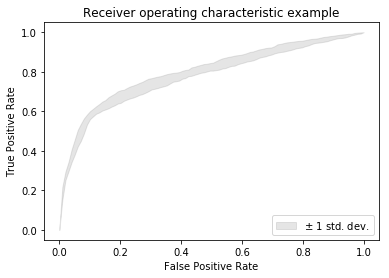

0.78952550717256598

In [57]:
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

mean_auc

In [39]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [12]:
n_iter=8
param_dist = {
    'task': ['train'],
    'boosting_type': ['gbdt', 'dart'],
#     'boosting_type': ['dart'],
    'objective': ['binary'],
    'metric': ['auc'],
    'eval_metric': ['auc'],
    'num_leaves': 2 ** np.arange(4, 7, 1),
    'learning_rate': 10 ** np.arange(-2.5, -1, 0.01),
    'feature_fraction': np.arange(0.7, 1.0, 0.05),
    'bagging_fraction': np.arange(0.7, 1.0, 0.05),
    'bagging_freq': 2 ** np.arange(4, 8, 1),
    'verbose': [0],
    'n_estimators': [200,300,400,500,600],
    'colsample_bytree' : [0.7,0.8,0.9,1],
    'subsample' : [0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
    'num_boost_rounds': [128, 256, 512],
}
estimator = lgb.LGBMClassifier(nthread=4,silent=False)#,categorical_feature=[list(X_train).index(catFeature) for catFeature in categorical_features])
clf = RandomizedSearchCV(estimator, param_distributions=param_dist,
                                   n_iter=n_iter,cv=5,scoring='roc_auc')



In [13]:
clf.fit(X,Y)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, learning_rate=0.1,
        max_depth=-1, min_child_samples=20, min_child_weight=0.001,
        min_split_gain=0.0, n_estimators=100, n_jobs=-1, nthread=4,
        num_leaves=31, objective=None, random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=False, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
          fit_params={}, iid=True, n_iter=8, n_jobs=1,
          param_distributions={'task': ['train'], 'boosting_type': ['dart'], 'objective': ['binary'], 'metric': ['auc'], 'eval_metric': ['auc'], 'num_leaves': array([16, 32, 64]), 'learning_rate': array([ 0.00316,  0.00324, ...,  0.0955 ,  0.09772]), 'feature_fraction': array([ 0.7 ,  0.75,  0.8 ,  0.85,  0.9...bda': [0, 1, 2, 5, 6, 7, 9, 10], 'is_unbalance': [True, False], 'num_boost_rounds': [128, 256, 512]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
     

In [14]:

#trust your CV!
best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('Raw AUC score:', score)
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

test_probs = clf.predict_proba(X_test.as_matrix())[:,1]

Raw AUC score: 0.788884192518
bagging_fraction: 0.95000000000000018
bagging_freq: 32
boosting_type: 'dart'
colsample_bytree: 0.9
eval_metric: 'auc'
feature_fraction: 0.69999999999999996
is_unbalance: False
learning_rate: 0.032359365692961224
metric: 'auc'
n_estimators: 400
num_boost_rounds: 512
num_leaves: 32
objective: 'binary'
reg_alpha: 0.5
reg_lambda: 2
subsample: 0.7
task: 'train'
verbose: 0


/usr/lib64/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)
